# **Elahe Khodaverdi - 810100132**
### **CA3 - HMM**
In this assignment, we intend to perform music genre classification using Hidden Markov Models (HMM). We will use Mel Frequency Cepstral Coefficients (MFCCs) as our feature space. These coefficients are used in speech recoggnition and music modeling, since they can be used as a feature basis for classification purposes.
We will train our model using the provided training data and then run it on our test data to measure its accuracy.

Firstly, we need to import the necessary libraries.

In [105]:
import os
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
import seaborn as sns
import python_speech_features as psf
import pandas as pd

For audio file sampling, we convert the files into 5-second segments. As mentioned, this process increases the accuracy of the model and augments the amount of data for training and testing purposes.
We also define the relevant variables, such as the dataset path and corresponding genres.

In [106]:
path = "data"
genres = ['blues', 'hiphop', 'metal', 'pop']
segment_duration = 5
num_states = 12

## **Preprocessing and feature extraction**

##### **1. Why is it necessary for the samples to have the same length?** 
In machine learning algorithms, samples are compared with each other to improve the performance of our model. When the samples have different lengths, it is possible that their features are not consistent, making it difficult to compare them. On the other hand, when the samples have the same length, we know that the classification is based on the patterns within the data, rather than other features such as the length of the music. Additionally, if the length of one audio file is longer than another file, it is possible that the longer file simply repeats certain patterns regularly, and the classifier may make errors in learning due to the repeated patterns in those files.

We divide the dataset into training data and test data

In [107]:
def extract_mfcc(audio_path):
    sampling_freq, audio = wavfile.read(audio_path)
    mfccs = psf.mfcc(audio, sampling_freq, nfft=551)
    return mfccs

def preprocess_audio_data(data_path, genre, segment_duration):
    segments = []
    genre_path = os.path.join(data_path, genre)
    audio_files = os.listdir(genre_path)
    for file in audio_files:
        file_path = os.path.join(genre_path, file)
        try:
            sr, audio = wavfile.read(file_path)
            duration = len(audio) / sr
            num_segments = int(duration / segment_duration)
            for i in range(num_segments):
                start = int(i * segment_duration * sr)
                end = int((i + 1) * segment_duration * sr)
                segment = audio[start:end]
                mfcc = psf.mfcc(segment, sr, nfft=551)
                segments.append(mfcc)
        except FileNotFoundError:
            continue
    return segments

def prepare_training_data(data_path, genre, segment_duration, test_size=0.2):
    segments = preprocess_audio_data(data_path, genre, segment_duration)
    X_train, X_test = train_test_split(
        segments, test_size=test_size, shuffle=True
    )
    return X_train, X_test

def plot_mfcc(genre_dir, genre):
    mfccs = []
    max_len = 0
    for filename in os.listdir(genre_dir):
        if filename.endswith('.wav'):
            audio_path = os.path.join(genre_dir, filename)
            mfcc = extract_mfcc(audio_path)
            if mfcc.shape[0] > max_len:
                max_len = mfcc.shape[0]
            mfccs.append(mfcc)
    for i in range(len(mfccs)):
        if mfccs[i].shape[0] < max_len:
            mfccs[i] = np.pad(mfccs[i], ((0, max_len - mfccs[i].shape[0]), (0, 0)))
    mean_mfcc = np.mean(mfccs, axis=0)
    plt.figure(figsize=(10, 4))
    sns.heatmap(mean_mfcc.T, cmap='coolwarm')
    plt.title('MFCC for ' + genre.capitalize())
    plt.show()
   

### Heat Map Plot

##### **2. Why are overlapping frames used in calculating MFCC?**
Overlapping frames are used in calculating MFCCs to ensure we don’t miss any important information in the audio signal. It helps capture details that might get lost between frames, minimizes spectral leakage, which can distort the signal and also improves time resolution, helping us capture fast changes in the audio.

##### **3. Why is it common to use 12 or 13 initial coefficients of MFCC in most audio-related projects?**

In most audio-related projects, it is common to use the first 12 or 13 coefficients of MFCC. These coefficients are selected because they contain the most relevant information related to formants and the spectral envelope. The lower frequency coefficients provide information about the spectral envelope, which is important for capturing vocal traits such as phonemes and formants. On the other hand, the higher frequency coefficients capture details about the glottal pulse, which is not typically of interest in these projects. By focusing on the first 12 or 13 coefficients, we can obtain the necessary information about the vocal traits and disregard the fast-changing spectral details provided by higher coefficients.

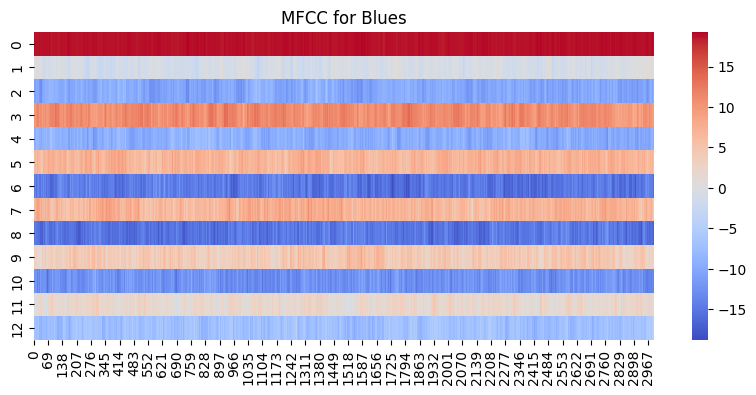

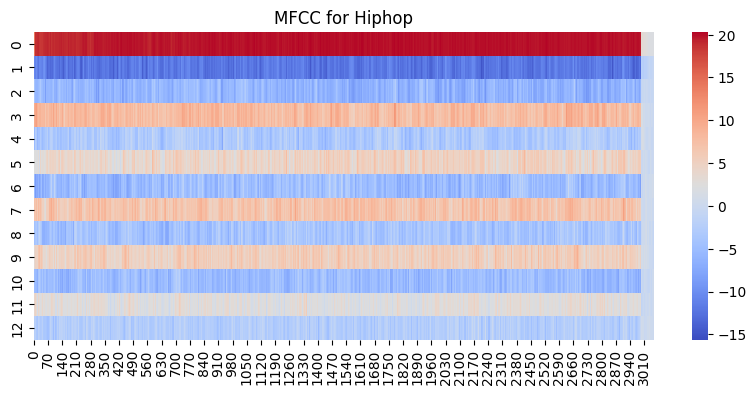

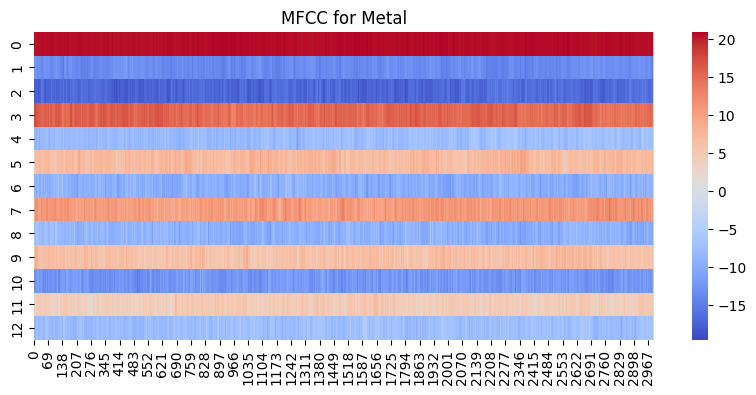

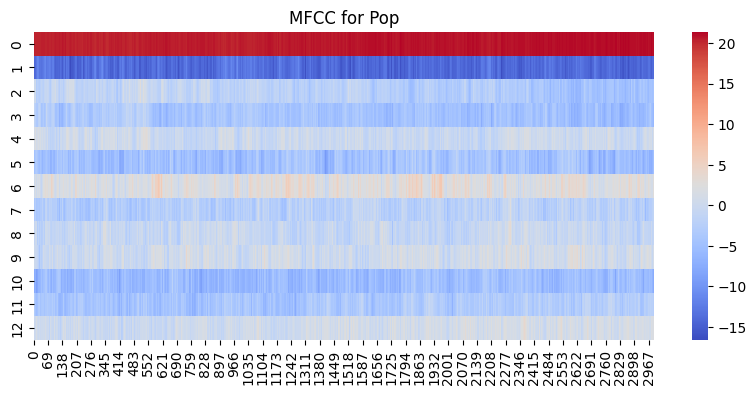

In [108]:
for genre in genres:
    genre_dir = os.path.join(path, genre)
    plot_mfcc(genre_dir,genre)

## **Getting Familiar with HMMs**

##### **1.**
States: These are the “hidden” part of the Hidden Markov Model. They represent the underlying process that we are interested in, but cannot directly observe.

Observations: these are directly measurable data that offer insights into a system’s state without explicitly revealing it. They’re derived from system-related features or variables.
In our model, the states are not defined and we can consider that their number is at most 13. In fact, we can consider each state as one coefficient of the MFCC. Also, in our model, the observation is essentially the data and information that the MFCC provides us.
##### **2.**
- ***First-Order HMM***: In this model, the probability of transitioning to the next state depends only on the current state. This is the most common type of HMM.
- ***Second-Order HMM***: In this model, the probability of transitioning to the next state depends on the current state and the state before it.
- ***Higher-Order HMM***: In these models, the transition probabilities depend on a longer history of previous states. The order of the HMM refers to how many previous states influence the transition probabilities.

Based on the description provided above, the model we will implement in this assignment is a first-order HMM. In this problem, the current state is determined solely by the previous MFCC coefficient. In other words, we can consider each MFCC coefficient as a "state," and the probability of transitioning to the next state depends only on the current state. 

##### **3.**
Some examples are as follows:
- ***Speach Recognition***
- ***Body Movement Recognition***
- ***Facial Expression Recognition***

And it is becuase the Hidden Markov Models are capable of modeling sequences of data where the current state depends only on a limited number of previous states. This makes HMMs suitable for modeling many temporal phenomena where there is a time dependency(or something like that).


##### **4.**
**Advantages**:
- ***Strong Statistical Foundation***: HMMs are based on solid statistical principles, making them reliable for modeling various phenomena.
- ***Efficient Learning Algorithms***: HMMs have powerful learning algorithms that can learn directly from raw sequence data.
- ***Consistent Treatment of Insertion and Deletion Penalties***: HMMs can handle changes in the data, such as insertions or deletions, in a consistent and learnable way.
- ***Handling Variable Length Inputs***: HMMs can work with inputs of different lengths, making them a flexible tool for analyzing sequence profiles.

**Disadvantages**:
- ***Independence Assumption***: HMMs assume that the current state depends only on the previous state. This Markov property may not hold in all real-world scenarios, where the current state may depend on multiple previous states or have complex dependencies.
- ***Training Complexity***: Training HMMs can be computationally expensive, especially when dealing with large datasets or complex models.
- ***Sensitivity to Model Initialization***: HMMs are sensitive to the initial values of the model parameters. Different initializations can lead to different local optima.
- ***Limited Expressiveness***: HMMs have limitations in representing complex relationships or capturing intricate patterns in data.

##### **5. Types of HMMs** 

- ***Standard Hidden Markov Model***: This is the basic form of an HMM. It's used when you have a sequence of observable data that is believed to be generated by a sequence of hidden states.

- ***Hidden Semi-Markov Model (HSMM)***: This variant of the HMM is used when the time duration spent in each state is significant. In a standard HMM, the state transition probabilities are independent of time, but in an HSMM, the state transition probabilities can depend on the time spent in the current state.

- ***Hierarchical Hidden Markov Model (HHMM)***: This type of HMM is used when there is a hierarchical relationship between the hidden states. Each state in an HHMM is itself an HHMM, allowing for complex, multi-level patterns to be modeled.

- ***Layered Hidden Markov Model (LHMM)***: This type of HMM is used when there are multiple levels of hidden states, with each level corresponding to a different level of abstraction or detail.

Also, there are models that are included below, which are based on the relationships and transitions between states.
- ***Ergodic Model Hidden Markov Model***:
- ***Left-Right Model Hidden Markov Model***:
- ***Mixed Model Hidden Markov Model***:

## **Implementing HMM**

In [111]:
def classify_audio(audio_segment, hmm_models):
    best_genre = None
    best_score = float('-inf')
    for genre, model in hmm_models.items():
        score = model.score(audio_segment)
        if score > best_score:
            best_score = score
            best_genre = genre
    return best_genre

In [112]:
X_train = {}
X_test = {}
for genre in genres:
    X_train[genre], X_test[genre] = prepare_training_data(
        path, genre, segment_duration
    )

### Part 1:

In [113]:
def train_hmm_models(X_train, num_states):
    model = hmm.GaussianHMM(n_components=num_states)
    segments = np.concatenate(X_train)
    model.fit(segments)
    return model

First we need to train our model for each genre. and then we can test them.

In [114]:
hmm_models_p1 = {}
for genre in genres:
    hmm_models_p1[genre] = train_hmm_models(X_train[genre], num_states)

In [115]:
predict_p1 = np.zeros((4, 4))
for i, genre in enumerate(genres):
    for test in X_test[genre]:
        predicted_genre = classify_audio(test, hmm_models_p1)
        j = genres.index(predicted_genre)
        predict_p1[i][j] += 1

### Part 2:

In [116]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None
        
    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)
        for t in range(T):
            if t == 0:
               alpha[:, t] = self.initial_prob.ravel()* observation_matrix[:, t]
            else:
               alpha[:, t] = np.dot(alpha[:, t - 1],self.transition_matrix) * observation_matrix[:, t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)
        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.transition_matrix,observation_matrix[:, t+1]* beta[:, t+1])
            beta[:, t] /= np.sum(beta[:, t])
        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T, mean=self.mean[:, s], cov=self.covariances[:, :, s])
        return B


    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))
        for t in range(T - 1):
            partial_sum = self.transition_matrix * np.dot(alpha[:, t], (B[:, t + 1] * beta[:, t + 1]))
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t]* beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,-1]* beta[:,-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:, 0]
        expected_transition = self._stochasticize(xi_sum)

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [117]:
hmm_models_p2 = {}
for genre in genres:
    hmm_model = HMM(num_hidden_states=num_states)
    for segment in X_train[genre]:
        segment_b = segment / np.amax(segment)
        hmm_model = hmm_model.train(segment_b.T,num_iterations=2)
    hmm_models_p2[genre] = hmm_model

In [118]:
predict_p2 = np.zeros((4, 4))
for i, genre in enumerate(genres):
    for test in X_test[genre]:
        test_b = test / np.amax(test)
        predicted_genre = classify_audio(test_b.T, hmm_models_p2)
        j = genres.index(predicted_genre)
        predict_p2[i][j] += 1

## **Model Evaluation**

In [119]:
def calculate_classification_metrics(genres, confusion_matrix):
    total_elements = np.sum(confusion_matrix)
    accuracy = np.trace(confusion_matrix) / total_elements
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)
    
    support = np.sum(confusion_matrix, axis=1)
    precision_weighted = np.sum(precision * support) / np.sum(support)
    recall_weighted = np.sum(recall * support) / np.sum(support)
    f1_weighted = np.sum(f1 * support) / np.sum(support)
    
    precision_micro = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    recall_micro = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    f1_micro = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)
    
    metrics_per_class = pd.DataFrame({
        'Genre': genres,
        'Accuracy' : accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    average_metrics = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Macro Average': [precision_macro, recall_macro, f1_macro],
        'Weighted Average': [precision_weighted, recall_weighted, f1_weighted],
        'Micro Average': [precision_micro, recall_micro, f1_micro]
    })
    
    return metrics_per_class, average_metrics


In [120]:
def plot_confusion_matrix(genres,predicted):
    plt.figure(figsize=(10,7))
    sns.heatmap(predicted, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', xticklabels=genres, yticklabels=genres);
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title('Confusion Matrix', size = 15);
    plt.show()

#### **1.** 
- **Accuracy**: The percentage of instances where our model have predicted the correct answer. generally it is a good metric to evaluate performance of a model, but when our data is imbalanced it can be misleading.
$$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$$
- **Precision**: The accuracy of positive predictions made by a model. It is defined as the ratio of true positive predictions to the total number of positive predictions made by the model. Precision is particularly useful when the cost of false positives is high, as it focuses on minimizing incorrect positive predictions.
$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$
- **Recall**: The model's ability to correctly identify positive instances. It is the ratio of true positives to the total number of actual positives. Recall is important when the cost of false negatives is high, as it minimizes the instances of incorrectly classifying positives as negatives.
$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$
- **F1 Score**: This metric takes the weighted average of precision and recall. It’s useful when you want to balance precision and recall and is particularly helpful when dealing with imbalanced datasets.
$$\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

## **2.**
***Precision*** measures the accuracy of positive predictions made by the model.

***Recall***, also known as sensitivity or true positive rate, measures the ability of the model to correctly identify all positive instances.


For example, let's consider the diagnosis of a disease. If our model only predicts someone as diseased with 100% certainty, our Precision would be high because no one is falsely diagnosed among the positive predictions. However, this model is not reliable because there might be cases where healthy individuals are mistakenly labeled as diseased. In such a scenario, our Recall could be low.

Alternatively, we can consider a model that either classifies all patients as healthy or considers those with a probability greater than 0 as diseased. In this case, our Recall would be high, but this model is not useful either because it might classify healthy individuals as diseased. In this situation, our Precision would likely be low.

## **3.**
The F1 score utilizes the harmonic mean for averaging. In this type of averaging, we give importance to the higher values of scores. For example, if one value is lower, our result will be closer to the lower value. In contrast, in regular averaging, all values have equal weight, and if one value is high, it significantly influences the overall average. Additionally, if a data point is an outlier or significantly smaller compared to other data points, its value may have a reduced impact on the overall average.

## **4.**
Multi-class metrics are used to evaluate the performance of classification models when there are more than two classes. Three common types of averaging methods used in multi-class metrics are macro, micro, and weighted averaging. Let me explain each of them:

- ***Macro Averaging***: In macro averaging, the metric is calculated independently for each class, and then the average of these individual metrics is taken. Each class is given equal weight in the calculation of the average, regardless of its size or imbalance in the dataset. Macro averaging treats all classes equally and is suitable when you want to evaluate the overall performance of the classifier without considering class imbalances.

- ***Micro Averaging***: In micro averaging, the metric is calculated by considering the total number of true positives, false positives, and false negatives across all classes. It treats each instance equally and calculates the metric by aggregating the contributions from each instance. Micro averaging is useful when you want to emphasize the overall performance of the classifier by considering the global counts of true positives, false positives, and false negatives.

- ***Weighted Averaging***: Weighted averaging takes into account the class imbalance by calculating the metric for each class and then averaging them based on the number of samples in each class. The weight assigned to each class is proportional to the number of samples in that class. This means that the performance of larger classes has a greater impact on the overall metric than smaller classes. Weighted averaging is suitable when you want to account for class imbalance in the evaluation of the classifier

## **5.**

#### Part 1 Evaluation

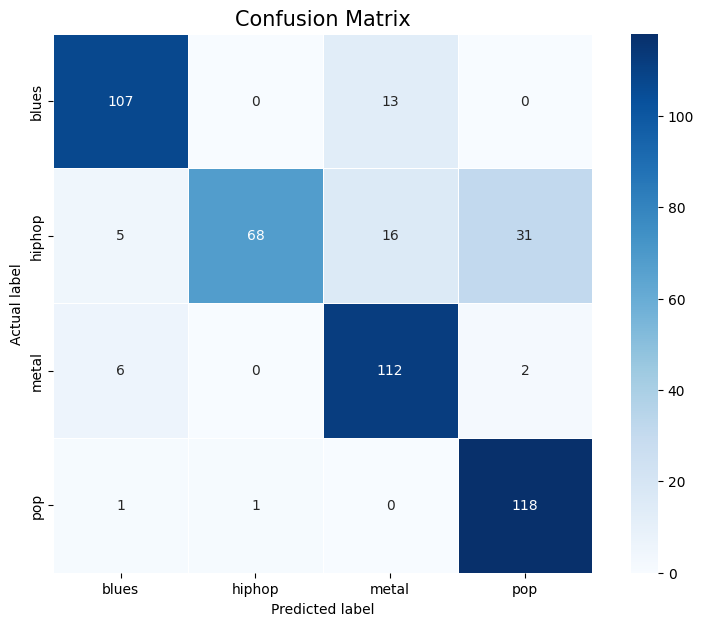

In [121]:
plot_confusion_matrix(genres,predict_p1)

In [122]:
metrics_per_class_p1, average_metrics_p1 = calculate_classification_metrics(genres,predict_p1)
metrics_per_class_p1

,Genre,Accuracy,Precision,Recall,F1 Score
0,blues,0.84375,0.899160,0.891667,0.895397
1,hiphop,0.84375,0.985507,0.566667,0.719577
2,metal,0.84375,0.794326,0.933333,0.858238
3,pop,0.84375,0.781457,0.983333,0.870849


In [123]:
average_metrics_p1

,Metric,Macro Average,Weighted Average,Micro Average
0,Precision,0.865113,0.865113,0.84375
1,Recall,0.843750,0.843750,0.84375
2,F1 Score,0.836015,0.836015,0.84375


#### Part 2 Evaluation

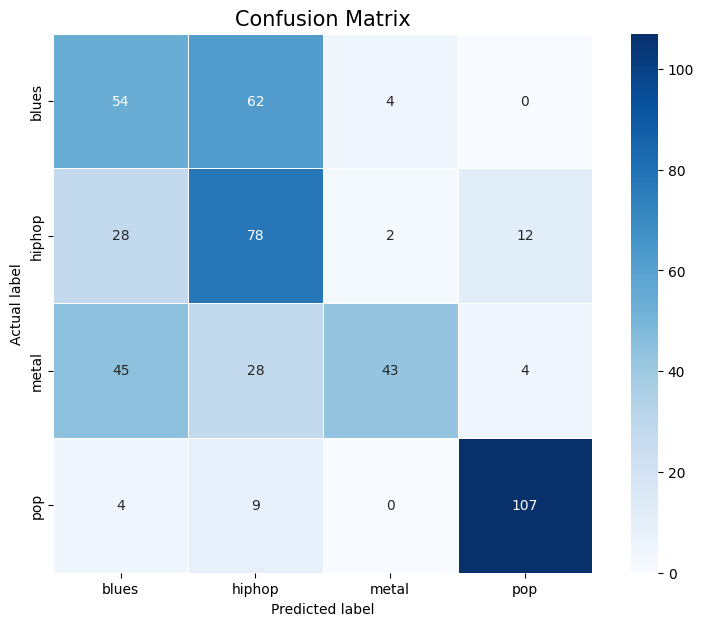

In [124]:
plot_confusion_matrix(genres,predict_p2)

In [125]:
metrics_per_class_p2, average_metrics_p2 = calculate_classification_metrics(genres,predict_p2)
metrics_per_class_p2

,Genre,Accuracy,Precision,Recall,F1 Score
0,blues,0.5875,0.412214,0.450000,0.430279
1,hiphop,0.5875,0.440678,0.650000,0.525253
2,metal,0.5875,0.877551,0.358333,0.508876
3,pop,0.5875,0.869919,0.891667,0.880658


In [126]:
average_metrics_p2

,Metric,Macro Average,Weighted Average,Micro Average
0,Precision,0.650090,0.650090,0.5875
1,Recall,0.587500,0.587500,0.5875
2,F1 Score,0.586266,0.586266,0.5875
